# Predicting and Understanding Daily Nutritional Patterns using Machine Learning


**Goal**: We utilize multiple publicly available datasets sourced from Kaggle to 
(1) predict calories from macro and micro nutrients,
(2) classify foods into healthy vs. less healthy patterns, 
(3) discover latent nutrient-based clusters, and 
(4) build a simple recommendation system for nutritionally similar foods.

Datasets used:

1. **Daily Food Log** – individual food entries with macros, sodium, cholesterol, meal type, and water intake.  
2. **Food Composition (USDA-like)** – detailed nutrient database with vitamins and minerals.  
3. **Legacy Nutrient Table** – older nutrient table with grams, calories, and macro composition.

We combine supervised learning, unsupervised learning, and model interpretation to build a complete view of daily nutritional patterns.


In [108]:
#import libraries
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, silhouette_score)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBRegressor
import shap

sys.path.append(os.path.abspath("../src"))
from data_prep import *
from modeling import *
from unsupervised import *
from recommend import *
from modeling import *

sns.set(style="whitegrid")



### Load Datasets

In [109]:
DATA_DIR = "../data"
df_daily = load_daily_log(os.path.join(DATA_DIR, "daily_food_nutrition_dataset.csv"))
df_food = load_food_composition(os.path.join(DATA_DIR, "food.csv"))
df_legacy = load_legacy_nutrients(os.path.join(DATA_DIR, "nutrients_csvfile.csv"))

### Data Overview

We start by understanding the structure of each dataset:

- **Daily Food Log**: each row is a food item consumed at a specific meal with macro nutrients and water intake.
- **Food Composition**: each row is a standardized food description with detailed nutrient content.
- **Legacy Nutrient Table**: a compact table focusing on grams, calories, and macro nutrients, useful as an independent reference.

We first inspect shapes, missingness, and basic distributions to understand scale and quality.


In [110]:
print("Daily log shape:", df_daily.shape)
print("Food composition shape:", df_food.shape)
print("Legacy nutrient shape:", df_legacy.shape)

display(df_daily.describe(include="all").T.head(15))
display(df_food.describe(include="all").T.head(15))
display(df_legacy.describe(include="all").T.head(15))

print("Unique daily food items:", df_daily["Food_Item"].nunique())
print("Daily categories:", df_daily["Category"].unique()[:10])
print("Daily meal types:", df_daily["Meal_Type"].unique())

Daily log shape: (645, 12)
Food composition shape: (7413, 48)
Legacy nutrient shape: (335, 10)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Food_Item,645,587,Tzatziki Sauce (2 tbsp),3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,645,46,Condiment,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Calories (kcal),645.0,NaN,NaN,NaN,146.294574,139.98436,0.0,42.0,105.0,200.0,680.0
Protein (g),645.0,NaN,NaN,NaN,6.30062,8.782683,0.0,0.5,2.7,7.0,45.0
Carbohydrates (g),645.0,NaN,NaN,NaN,15.435194,16.34923,0.0,1.3,9.2,27.0,70.0
Fat (g),645.0,NaN,NaN,NaN,6.469612,8.142916,0.0,0.2,3.0,10.0,40.0
Fiber (g),645.0,NaN,NaN,NaN,1.702481,2.121275,0.0,0.0,1.0,3.0,14.0
Sugars (g),645.0,NaN,NaN,NaN,5.294264,8.537343,0.0,0.4,2.0,6.0,60.0
Sodium (mg),645.0,NaN,NaN,NaN,246.331783,308.472431,0.0,5.0,120.0,350.0,1580.0
Cholesterol (mg),645.0,NaN,NaN,NaN,20.482171,43.560072,0.0,0.0,0.0,25.0,450.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Category,7413,1183,BEEF,457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,7413,7409,"WORTHINGTON DINNER RST,FRZ,UNPREP",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nutrient Data Bank Number,7413.0,NaN,NaN,NaN,14116.44368,8767.416214,1001.0,8121.0,12539.0,18424.0,93600.0
Data.Alpha Carotene,7413.0,NaN,NaN,NaN,21.210711,269.714183,0.0,0.0,0.0,0.0,14251.0
Data.Ash,7413.0,NaN,NaN,NaN,1.852459,2.993228,0.0,0.83,1.24,2.2,99.8
Data.Beta Carotene,7413.0,NaN,NaN,NaN,159.043437,1126.285026,0.0,0.0,0.0,1.0,42891.0
Data.Beta Cryptoxanthin,7413.0,NaN,NaN,NaN,8.776744,154.18486,0.0,0.0,0.0,0.0,7923.0
Data.Carbohydrate,7413.0,NaN,NaN,NaN,21.785381,27.123491,0.0,0.49,9.29,30.59,100.0
Data.Cholesterol,7413.0,NaN,NaN,NaN,37.162822,119.738438,0.0,0.0,2.0,60.0,3100.0
Data.Choline,7413.0,NaN,NaN,NaN,20.673546,45.48199,0.0,0.0,0.0,20.0,1388.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Food,335,329,Butter,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Measure,335,61,1 cup,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Grams,334.0,NaN,NaN,NaN,139.392216,119.934587,11.0,60.0,108.0,200.0,984.0
Calories,330.0,NaN,NaN,NaN,179.806061,155.644631,0.0,75.0,130.0,245.0,992.0
Protein,335.0,NaN,NaN,NaN,8.573134,17.733722,-1.0,1.0,3.0,12.0,232.0
Fat,334.0,NaN,NaN,NaN,8.565868,19.822035,0.0,0.0,1.0,10.0,233.0
Sat.Fat,333.0,NaN,NaN,NaN,6.438438,18.517656,0.0,0.0,0.0,8.0,234.0
Fiber,334.0,NaN,NaN,NaN,2.376078,16.078272,0.0,0.0,0.2,1.0,235.0
Carbs,335.0,NaN,NaN,NaN,24.982388,35.833106,0.0,3.0,14.0,30.5,236.0
Category,335,16,"Breads, cereals, fastfood,grains",45,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unique daily food items: 587
Daily categories: ['Protein/Dairy' 'Grain' 'Beverage' 'Fruit' 'Meal/Protein' 'Protein/Fish'
 'Vegetable' 'Dairy' 'Nut' 'Meal/Processed']
Daily meal types: ['Breakfast' 'Lunch' 'Snack' 'Dinner' 'Side']


### Feature Engineering
We add several derived features to enrich the dataset:

- Macro ratios (Protein/Carbs/Fat as % of total macros)

- Energy density (kcal per gram of macros)

- Healthy label (simple heuristic using sugar, fat, and fiber)

These features help improve model performance.

In [111]:
#macro ratios & energy density
df_daily_fe = data_prep.add_macro_ratios(df_daily)
df_daily_fe = data_prep.add_energy_density(df_daily_fe)

#healthy label
df_daily_fe["Healthy"] = data_prep.define_healthy_label(df_daily_fe)


Categorical variables (Category, Meal_Type) are label-encoded.
Numerical columns are standardized for models sensitive to scale (LR, NN, PCA, clustering).

In [112]:
#Encode categoricals
df_daily_encoded, label_encoders = data_prep.encode_categoricals(
    df_daily_fe,
    cols=("Category", "Meal_Type")
)

#numeric columns
numeric_cols = [
    "Protein (g)",
    "Carbohydrates (g)",
    "Fat (g)",
    "Fiber (g)",
    "Sugars (g)",
    "Sodium (mg)",
    "Cholesterol (mg)",
    "Water_Intake (ml)",
    "Protein_Ratio",
    "Carb_Ratio",
    "Fat_Ratio",
    "Energy_Density_kcal_per_g_macro",
]

df_daily_scaled, scaler = data_prep.scale_features(df_daily_encoded, numeric_cols)
df_daily_scaled = data_prep.clean_numeric(df_daily_scaled)
df_daily_scaled.head()

,Food_Item,Category,Calories (kcal),Protein (g),Carbohydrates (g),Fat (g),Fiber (g),Sugars (g),Sodium (mg),Cholesterol (mg),Meal_Type,Water_Intake (ml),Protein_Ratio,Carb_Ratio,Fat_Ratio,Energy_Density_kcal_per_g_macro,Healthy
0,Scrambled Eggs (2 large),31,180,0.649437,-0.822401,0.925495,-0.803197,-0.503388,-0.215200,8.030039,0,1.323634,1.036835,-1.468252,1.184955,-0.013812,0
1,Whole Wheat Toast (1 slice),11,80,-0.262153,-0.087852,-0.672223,0.140364,-0.386165,-0.344972,-0.470570,0,-0.501572,0.004037,0.549212,-0.702402,-0.067673,0
2,Coffee (black),0,5,-0.683763,-0.944826,-0.782834,-0.803197,-0.620611,-0.782952,-0.470570,0,-0.501572,2.559322,-1.684816,0.130256,0.133621,0
3,Banana,10,105,-0.569815,0.707910,-0.745964,0.659322,1.020516,-0.795929,-0.470570,0,-0.501572,-0.778596,1.167490,-0.865645,-0.081077,0
4,Grilled Chicken Salad,23,350,2.700516,-0.332701,1.662904,1.555705,-0.151718,0.498545,1.367400,2,3.148840,1.375166,-1.179500,0.481822,-0.028266,1


### Exploratory Data Analysis (Daily Log)

We visualize correlations between nutrients and engineered features.

- Fat & carbs drive most variation in calories

- Sugar correlates strongly with carbs

- Energy density aligns more with fat than protein

These insights help decide model approaches.


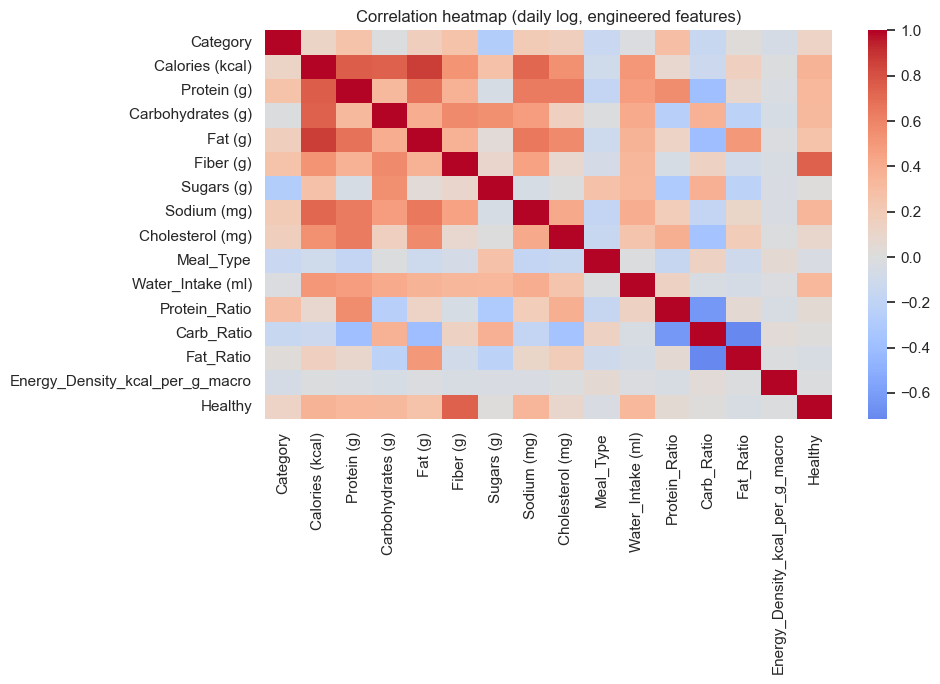

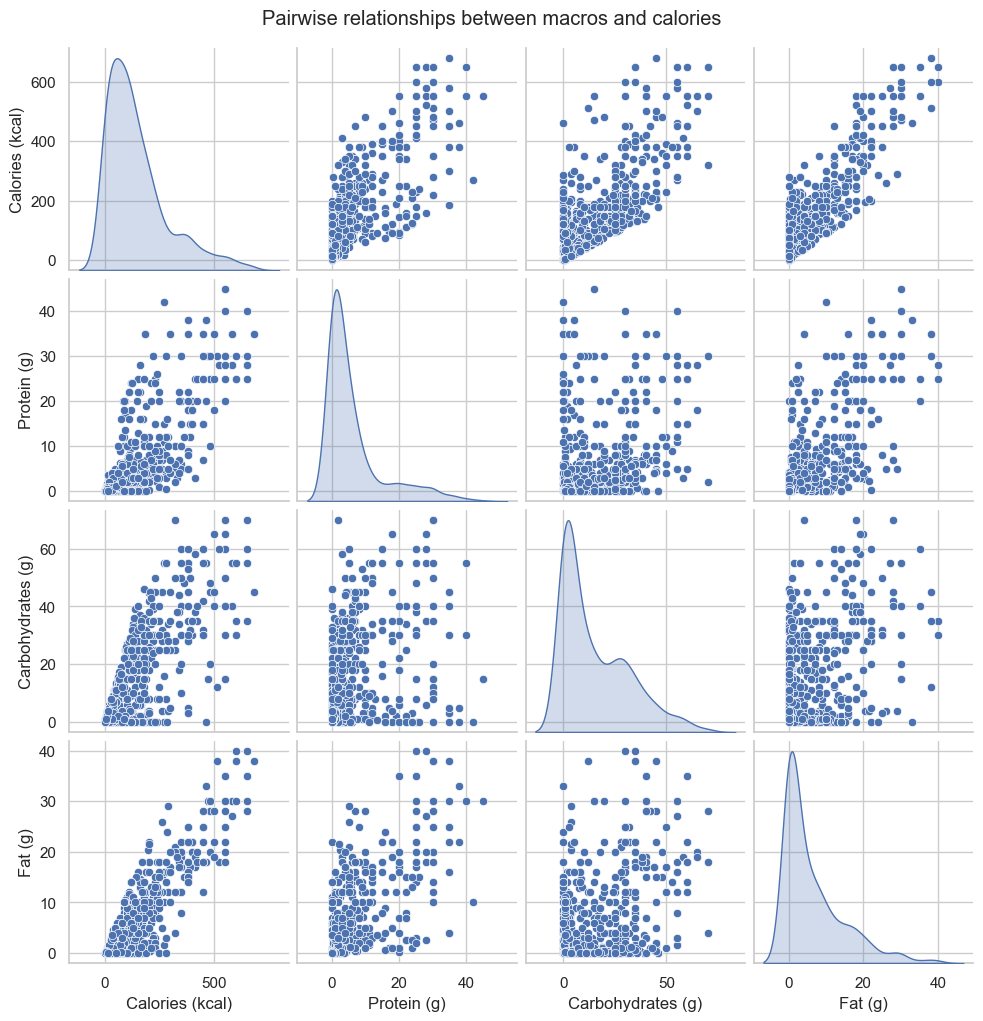

In [113]:
plt.figure(figsize=(10, 7))
corr = df_daily_scaled.drop(columns=["Food_Item"]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (daily log, engineered features)")
plt.tight_layout()
plt.show()

# Pairplot for main macros and calories (before scaling, to keep units interpretable)
sns.pairplot(
    df_daily_fe[
        ["Calories (kcal)", "Protein (g)", "Carbohydrates (g)", "Fat (g)"]
    ],
    diag_kind="kde"
)
plt.suptitle("Pairwise relationships between macros and calories", y=1.02)
plt.show()


### Regression Models — Predicting Calories
We train three baseline models:

- Linear Regression

- Random Forest Regressor

- XGBoost Regressor

and then we evaluate using MAE, RMSE, and R².

These models show how well nutrients predict calorie content.

In [114]:
# Remove non-numeric columns
df_reg = df_daily_scaled.drop(columns=["Healthy", "Food_Item"])

# Split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = modeling.split_regression(
    df_reg,
    target_col="Calories (kcal)",
    test_size=0.2,
    random_state=42
)

baseline_models, baseline_preds, baseline_metrics = modeling.train_baseline_regressors(
    X_train_reg, y_train_reg, X_test_reg, y_test_reg
)

baseline_metrics


,Model,MAE,RMSE,R2
0,XGBoost (baseline),8.982543,17.201528,0.986066
1,Random Forest (baseline),10.211085,17.815737,0.985053
2,Linear Regression (baseline),41.393798,397.797754,-6.451791


In [115]:
# Hyperparameter tuning
rf_tuned, pred_rf_tuned, rf_metrics, rf_best_params = modeling.tune_random_forest(
    X_train_reg, y_train_reg, X_test_reg, y_test_reg
)
xgb_tuned, pred_xgb_tuned, xgb_metrics, xgb_best_params = modeling.tune_xgboost(
    X_train_reg, y_train_reg, X_test_reg, y_test_reg
)

# Stacking ensemble
stack_model, pred_stack, stack_metrics = modeling.build_stacking_ensemble(
    X_train_reg, y_train_reg, X_test_reg, y_test_reg,
    rf_tuned, xgb_tuned
)

comparison_rows = list(baseline_metrics.to_dict("records"))
comparison_rows.append(rf_metrics)
comparison_rows.append(xgb_metrics)
comparison_rows.append(stack_metrics)

model_comparison = pd.DataFrame(comparison_rows).sort_values("RMSE").reset_index(drop=True)
model_comparison


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


,Model,MAE,RMSE,R2
0,XGBoost (tuned),8.758841,16.243044,0.987576
1,XGBoost (baseline),8.982543,17.201528,0.986066
2,Random Forest (baseline),10.211085,17.815737,0.985053
3,Random Forest (tuned),14.160347,23.172631,0.974714
4,Stacking Ensemble,8.373178,31.386841,0.953609
5,Linear Regression (baseline),41.393798,397.797754,-6.451791


Best model according to RMSE: XGBoost (tuned)


,Actual,Predicted,Residual
count,129.000000,129.000000,129.000000
mean,150.395349,149.789764,0.605579
std,146.292431,142.621674,16.295033
min,0.000000,0.737153,-60.496487
25%,40.000000,44.945484,-2.591461
50%,110.000000,110.874062,-0.037599
75%,200.000000,205.918320,2.733791
max,650.000000,603.895325,58.619446


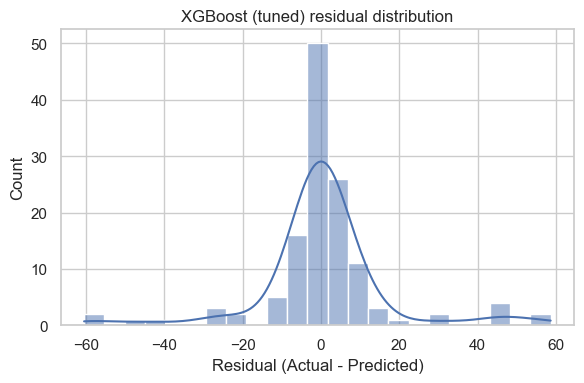

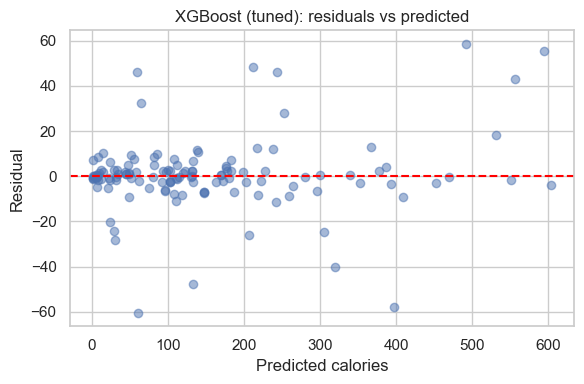

In [116]:
best_row = model_comparison.iloc[0]
best_name = best_row["Model"]
print("Best model according to RMSE:", best_name)

if "Stacking" in best_name:
    best_pred = pred_stack
elif "XGBoost (tuned)" in best_name:
    best_pred = pred_xgb_tuned
elif "Random Forest (tuned)" in best_name:
    best_pred = pred_rf_tuned
else:
    best_pred = baseline_preds.get(best_name, pred_stack)

residuals_df = pd.DataFrame({
    "Actual": y_test_reg.values,
    "Predicted": best_pred
})
residuals_df["Residual"] = residuals_df["Actual"] - residuals_df["Predicted"]
display(residuals_df.describe())

plt.figure(figsize=(6, 4))
sns.histplot(residuals_df["Residual"], kde=True)
plt.title(f"{best_name} residual distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(residuals_df["Predicted"], residuals_df["Residual"], alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted calories")
plt.ylabel("Residual")
plt.title(f"{best_name}: residuals vs predicted")
plt.tight_layout()
plt.show()


### Neural Network Regression
We train a small feed-forward neural network to compare against tree-based models. Features: Two dense layers (ReLU), Adam optimizer, Early stopping, Scaled inputs.

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select subset of features for NN (raw scale -> new scaler)
nn_features = [
    "Protein (g)",
    "Carbohydrates (g)",
    "Fat (g)",
    "Sugars (g)",
    "Fiber (g)",
    "Sodium (mg)",
    "Cholesterol (mg)",
]

df_nn = df_daily_fe.copy()
X_nn = df_nn[nn_features]
y_nn = df_nn["Calories (kcal)"]

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=42
)

scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_test_nn_scaled = scaler_nn.transform(X_test_nn)

nn_model, nn_history = modeling.build_and_train_nn(X_train_nn_scaled, y_train_nn.values)
y_pred_nn, nn_metrics = modeling.evaluate_nn(nn_model, X_test_nn_scaled, y_test_nn)

nn_metrics


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 38104.6445 - mae: 141.5335 - mse: 38104.6445 - val_loss: 47535.1055 - val_mae: 157.6692 - val_mse: 47535.1055
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37797.6953 - mae: 140.8104 - mse: 37797.6953 - val_loss: 47085.5977 - val_mae: 156.7916 - val_mse: 47085.5977
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37383.5547 - mae: 139.8905 - mse: 37383.5547 - val_loss: 46442.6094 - val_mae: 155.5905 - val_mse: 46442.6094
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36800.7812 - mae: 138.6041 - mse: 36800.7812 - val_loss: 45520.8555 - val_mae: 153.9368 - val_mse: 45520.8555
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35955.6133 - mae: 136.8507 - mse: 35955.6133 - val_loss: 44249.1680 - val_mae: 151.7369 - val_mse: 44249.1680
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34821.5508 - mae: 134.5719 - mse: 34821.5508 - val_loss: 42531.8477 - val_mae: 148.8624 - val_m

{'Model': 'Neural Network (Keras)',
 'MAE': 9.491957664489746,
 'RMSE': np.float64(18.3137889838056),
 'R2': 0.984205961227417}

In [118]:
model_comparison = pd.concat(
    [
        model_comparison,
        pd.DataFrame([nn_metrics]),
    ],
    ignore_index=True
).sort_values("RMSE").reset_index(drop=True)

model_comparison


,Model,MAE,RMSE,R2
0,XGBoost (tuned),8.758841,16.243044,0.987576
1,XGBoost (baseline),8.982543,17.201528,0.986066
2,Random Forest (baseline),10.211085,17.815737,0.985053
3,Neural Network (Keras),9.491958,18.313789,0.984206
4,Random Forest (tuned),14.160347,23.172631,0.974714
5,Stacking Ensemble,8.373178,31.386841,0.953609
6,Linear Regression (baseline),41.393798,397.797754,-6.451791


### Classification — Healthy vs Not Healthy
Using the engineered healthy label, we train:

- Logistic Regression

- Decision Tree

We evaluate accuracy, precision, recall, F1, and confusion matrix.

Logistic Regression report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       115
           1       0.92      0.86      0.89        14

    accuracy                           0.98       129
   macro avg       0.95      0.92      0.94       129
weighted avg       0.98      0.98      0.98       129

Decision Tree report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       115
           1       1.00      1.00      1.00        14

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



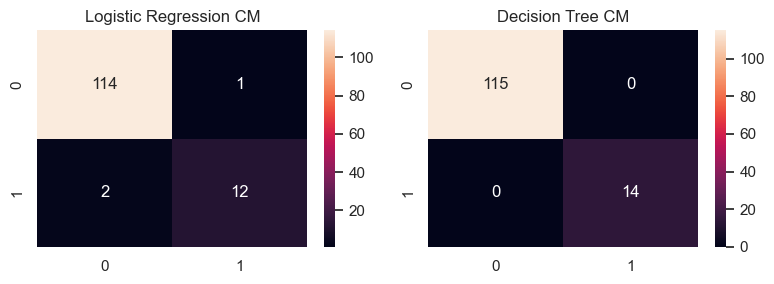

In [119]:
# Remove string column before classification
df_clf = df_daily_scaled.drop(columns=["Food_Item"]).copy()

# Add the Healthy label
df_clf["Healthy"] = df_daily_fe["Healthy"].values

# Split classification data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = modeling.split_classification(
    df_clf,
    label_col="Healthy",
    test_size=0.2,
    random_state=42
)

# Train models
clf_reports = modeling.train_classifiers(X_train_clf, y_train_clf, X_test_clf, y_test_clf)

print("Logistic Regression report:\n", clf_reports["logistic"]["report"])
print("Decision Tree report:\n", clf_reports["tree"]["report"])

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
sns.heatmap(clf_reports["logistic"]["cm"], annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Logistic Regression CM")

sns.heatmap(clf_reports["tree"]["cm"], annot=True, fmt="d", ax=axes[1])
axes[1].set_title("Decision Tree CM")
plt.tight_layout()
plt.show()


### Unsupervised Learning: Nutrient-based Clusters

We use K-means and hierarchical clustering to discover nutrient-based clusters:

- On the **daily log**, clusters represent typical *meals* or *food choices*.
- On the **food composition dataset**, clusters represent broader nutrient archetypes (e.g., high-fat dairy, starchy grains, etc.).


KMeans silhouette (daily log): 0.44196695983420037


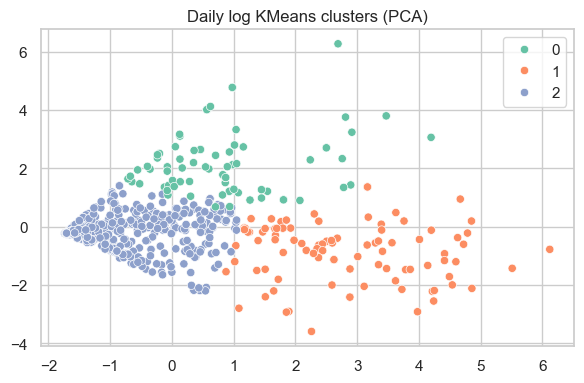

In [120]:
# Daily log clustering on macro features
cluster_features = ["Protein (g)", "Carbohydrates (g)", "Fat (g)", "Fiber (g)", "Sugars (g)"]
X_cluster_daily = df_daily_scaled[cluster_features]

km_daily, labels_km_daily, sil_daily = unsupervised.run_kmeans(X_cluster_daily, n_clusters=3)
agg_daily, labels_agg_daily = unsupervised.run_agglomerative(X_cluster_daily, n_clusters=3)
pca_daily, pca_vals_daily = unsupervised.compute_pca(X_cluster_daily, n_components=2)

print("KMeans silhouette (daily log):", sil_daily)

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=pca_vals_daily[:, 0],
    y=pca_vals_daily[:, 1],
    hue=labels_km_daily,
    palette="Set2"
)
plt.title("Daily log KMeans clusters (PCA)")
plt.tight_layout()
plt.show()


In [121]:
daily_u, food_u, legacy_u = data_prep.unify_macro_schema(df_daily_fe, df_food, df_legacy)
summary_stats = unsupervised.compare_macro_distributions(daily_u, food_u, legacy_u)

for name, summary in summary_stats.items():
    print(f"=== {name} ===")
    display(summary)


=== Daily Log ===


,Calories,Protein (g),Carbohydrates (g),Fat (g),Fiber (g)
count,645.000000,645.000000,645.000000,645.000000,645.000000
mean,146.294574,6.300620,15.435194,6.469612,1.702481
std,139.984360,8.782683,16.349230,8.142916,2.121275
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,0.500000,1.300000,0.200000,0.000000
50%,105.000000,2.700000,9.200000,3.000000,1.000000
75%,200.000000,7.000000,27.000000,10.000000,3.000000
max,680.000000,45.000000,70.000000,40.000000,14.000000


=== Food Composition ===


,Protein (g),Carbohydrates (g)
count,7413.000000,7413.000000
mean,10.809883,21.785381
std,10.483772,27.123491
min,0.000000,0.000000
25%,2.130000,0.490000
50%,7.270000,9.290000
75%,18.580000,30.590000
max,88.320000,100.000000


=== Legacy ===


,Calories,Protein (g),Fat (g),Carbohydrates (g)
count,330.000000,335.000000,334.000000,335.000000
mean,179.806061,8.573134,8.565868,24.982388
std,155.644631,17.733722,19.822035,35.833106
min,0.000000,-1.000000,0.000000,0.000000
25%,75.000000,1.000000,0.000000,3.000000
50%,130.000000,3.000000,1.000000,14.000000
75%,245.000000,12.000000,10.000000,30.500000
max,992.000000,232.000000,233.000000,236.000000


### Cross-Dataset Macro Comparison
We unify macro schemas across:

- Daily log

- Food composition

- Legacy nutrient table

We then compare macro means and distributions. This helps verify whether nutrient patterns are consistent across different sources.

In [122]:
from recommend import build_food_profile_matrix, cosine_similarity_recommender

nutrient_cols = [
    "Calories (kcal)",
    "Protein (g)",
    "Carbohydrates (g)",
    "Fat (g)",
    "Fiber (g)",
    "Sugars (g)",
    "Sodium (mg)",
    "Cholesterol (mg)",
]

food_profiles = build_food_profile_matrix(df_daily_fe, nutrient_cols=nutrient_cols)
sim_df, recommend_fn = cosine_similarity_recommender(food_profiles)

example_food = food_profiles.index[0]
print("Query food:", example_food)
print("\nRecommended similar foods (cosine similarity):")
print(recommend_fn(example_food, top_n=5))


Query food: Acai Bowl (1 serving)

Recommended similar foods (cosine similarity):
Food_Item
Amaretti Cookie (2 cookies)    0.998776
Onions (sautéed 1/4 cup)       0.998614
Gochugaru (1 tsp)              0.998047
Cucumber (1/4 cup side)        0.997768
Cucumber Slices (1 cup)        0.997712
Name: Acai Bowl (1 serving), dtype: float64
